In [32]:
import pandas as pd

from os.path import join

In [3]:
DATA_BASE_PATH = '../data/'

In [4]:
virtual_trading_dataset = pd.read_csv(join(DATA_BASE_PATH, 'virtual_trading_data.csv'))
virtual_trading_dataset["date"] = pd.to_datetime(virtual_trading_dataset["date"])

In [29]:
def feature_extraction(df_time_series):
    spp_name = df_time_series['settlementPoint'].unique()[0]
    # 1. Basic Statistical Features
    mean_returns = df_time_series['return_DA_RT'].mean()
    std_returns = df_time_series['return_DA_RT'].std()
    skew_returns = df_time_series['return_DA_RT'].skew()
    kurt_returns = df_time_series['return_DA_RT'].kurt()
    max_return = df_time_series['return_DA_RT'].max()
    min_return = df_time_series['return_DA_RT'].min()
    median_return = df_time_series['return_DA_RT'].median()

    # 2. Volatility Features
    # 2.1. Rolling Standard Deviation
    rolling_std = df_time_series['return_DA_RT'].rolling(window=24).std().mean()
    # 2.2. Mean Absolute Deviation
    mad = (df_time_series['return_DA_RT'] - df_time_series['return_DA_RT'].mean()).abs().mean()
    # 2.3. Difference between the max and min returns over the last 24 hours
    max_min_diff = df_time_series['return_DA_RT'].rolling(window=24).apply(lambda x: x.max() - x.min()).mean()

    # Risk metrics
    var_return = df_time_series['return_DA_RT'].quantile(0.05)
    expected_shortfall_return = df_time_series['return_DA_RT'][df_time_series['return_DA_RT'] < var_return].mean()
    drawdown = (df_time_series['return_DA_RT'] - df_time_series['return_DA_RT'].cummax()).min()

    # Returns distribution
    proportion_positiv_ret = len(df_time_series['return_DA_RT'] > 0) / len(df_time_series)
    proportion_negativ_ret = 1.0 - proportion_positiv_ret
    return_25_quantile = df_time_series['return_DA_RT'].quantile(0.25)
    return_50_quantile = df_time_series['return_DA_RT'].quantile(0.50)
    return_75_quantile = df_time_series['return_DA_RT'].quantile(0.75)

    # Time-Domain Features
    avg_h_returns = []
    std_h_returns = []
    for h in range(24):
        avg_h_returns.append(df_time_series[df_time_series['hour'] == h]['return_DA_RT'].mean())
        std_h_returns.append(df_time_series[df_time_series['hour'] == h]['return_DA_RT'].std())

    # 24 hours mean cumulative returns
    # Reset the cumulative sum at the beginning of each day
    df_time_series['cumulative_return'] = df_time_series['return_DA_RT'].cumsum()
    df_time_series['cumulative_return'] = df_time_series['cumulative_return'] - df_time_series['cumulative_return'].shift(24)
    mean_cum_returns = df_time_series['cumulative_return'].mean()

    # Return a dataframe
    return pd.DataFrame({
        'mean_returns': mean_returns,
        'std_returns': std_returns,
        'skew_returns': skew_returns,
        'kurt_returns': kurt_returns,
        'max_return': max_return,
        'min_return': min_return,
        'median_return': median_return,
        'rolling_std': rolling_std,
        'mad': mad,
        'max_min_diff': max_min_diff,
        'var_return': var_return,
        'expected_shortfall_return': expected_shortfall_return,
        'drawdown': drawdown,
        'proportion_positiv_ret': proportion_positiv_ret,
        'proportion_negativ_ret': proportion_negativ_ret,
        'return_25_quantile': return_25_quantile,
        'return_50_quantile': return_50_quantile,
        'return_75_quantile': return_75_quantile,
        # hourly
        **{
            f'avg_{h}_returns': avg_h_returns[h] for h in range(24)
        },
        **{
            f'std_{h}_returns': std_h_returns[h] for h in range(24)
        },
        'mean_cum_returns': mean_cum_returns
    }, index=[spp_name])


In [31]:
virtual_trading_dataset["hour"] = virtual_trading_dataset["date"].dt.hour

In [33]:
df_features = virtual_trading_dataset.groupby('settlementPoint').apply(feature_extraction)

/tmp/ipykernel_45634/4138314941.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features = virtual_trading_dataset.groupby('settlementPoint').apply(feature_extraction)


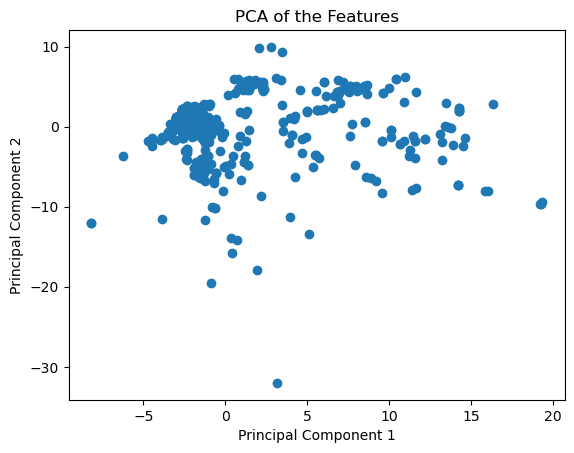

In [35]:
# PCA to reduce the dimensionality of the features and see if we can find some patterns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df_features)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the PCA results
import matplotlib.pyplot as plt

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of the Features")
plt.show()